<a href="https://colab.research.google.com/github/suhyeon0325/BELKA-DrugPredict/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 라이브러리 임포트

In [2]:
! pip install rdkit

In [3]:
!pip install duckdb

In [4]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 분자 데이터 처리
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.Draw import IPythonConsole

# 머신러닝
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 딥러닝
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D

# 기타 유틸리티
import duckdb
import os
import sys
import json
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

In [36]:
from collections import defaultdict

## 데이터 불러오기

In [5]:
# Parquet 파일 경로 지정
train_path = '/content/drive/MyDrive/BELKA-DrugPredict/data/train.parquet'

con = duckdb.connect()

train = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 50000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 50000)""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,191718682,O=C(Nc1ccc(C(=O)O)cc1F)OCC1c2ccccc2-c2ccccc21,Nc1ncc(F)cn1,CCOC(=O)c1c[nH]nc1N,CCOC(=O)c1c[nH]nc1Nc1nc(Nc2ncc(F)cn2)nc(Nc2ccc...,HSA,0
1,78960424,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NCc1nc2cnccc2s1,NCc1cccnc1N1CCC(C(N)=O)CC1,NC(=O)C1CCN(c2ncccc2CNc2nc(NCc3nc4cnccc4s3)nc(...,HSA,0
2,78396817,O=C(NC1(C(=O)O)CCCC1)OCC1c2ccccc2-c2ccccc21,Nc1nc(Cl)cc(Cl)n1,Nc1ccc(CC2COC(=O)N2)cc1,O=C1NC(Cc2ccc(Nc3nc(Nc4nc(Cl)cc(Cl)n4)nc(NC4(C...,HSA,0
3,211251222,O=C(Nc1cccc(C(=O)O)c1C(=O)O)OCC1c2ccccc2-c2ccc...,Nc1cccc(CN2CCCCC2)c1,Nc1[nH]c(=O)ncc1F,O=C(N[Dy])c1cccc(Nc2nc(Nc3cccc(CN4CCCCC4)c3)nc...,BRD4,0
4,205193578,O=C(Nc1ccc([N+](=O)[O-])cc1C(=O)O)OCC1c2ccccc2...,Cc1cc(N)n(-c2ccccc2)n1,Cl.NCC(=O)NC1CCC1,Cc1cc(Nc2nc(NCC(=O)NC3CCC3)nc(Nc3ccc([N+](=O)[...,HSA,0


## 기초 EDA

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     100000 non-null  int64  
 1   buildingblock1_smiles  100000 non-null  object 
 2   buildingblock2_smiles  100000 non-null  object 
 3   buildingblock3_smiles  100000 non-null  object 
 4   molecule_smiles        100000 non-null  object 
 5   protein_name           100000 non-null  object 
 6   binds                  100000 non-null  int64  
 7   mol_size               100000 non-null  int64  
 8   smiles_length          100000 non-null  int64  
 9   logP                   100000 non-null  float64
 10  molecular_weight       100000 non-null  float64
 11  num_h_donors           100000 non-null  int64  
 12  num_h_acceptors        100000 non-null  int64  
 13  graph                  100000 non-null  object 
 14  graph_size             100000 non-nul

In [7]:
# 고유값 확인
train.nunique()

id                       100000
buildingblock1_smiles       271
buildingblock2_smiles       693
buildingblock3_smiles       871
molecule_smiles           99900
protein_name                  3
binds                         2
dtype: int64

## 심화 EDA


1. 분자 크기와 바인딩 여부의 관계 파악하기

In [9]:
# 분자 크기 계산
train['mol_size'] = train['molecule_smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())

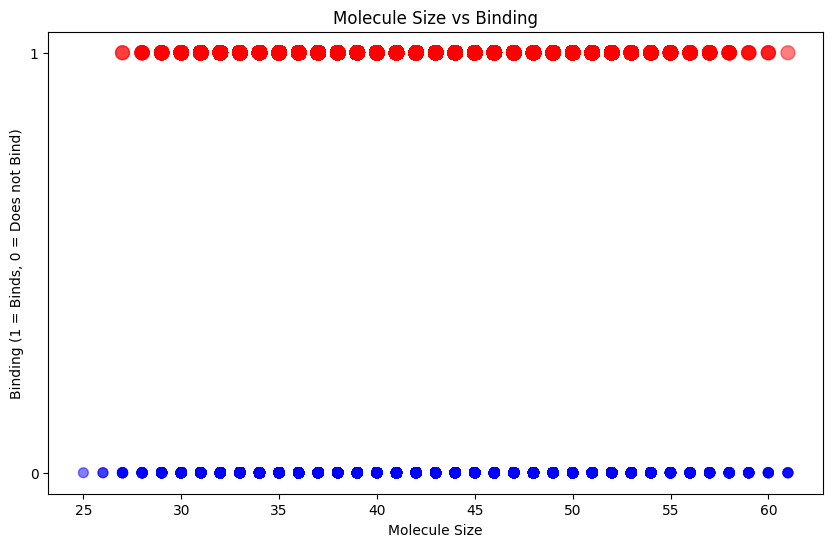

In [21]:
# 분자 크기와 바인딩 여부의 관계 시각화
# 바인딩 여부에 따라 점의 색상 지정
colors = train['binds'].map({0: 'blue', 1: 'red'})

# 바인딩 여부에 따라 점의 크기 설정 (빈도수에 따라 다르게)
sizes = np.where(train['binds'] == 1, 100, 50)  # 바인딩 여부에 따라 점의 크기 설정

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(train['mol_size'], train['binds'], c=colors, s=sizes, alpha=0.5)
ax.set_xlabel('Molecule Size')
ax.set_ylabel('Binding (1 = Binds, 0 = Does not Bind)')
ax.set_yticks([0, 1])
ax.set_title('Molecule Size vs Binding')
plt.show()

2. SMILES 문자열의 길이 분포 분석

In [22]:
# SMILES 길이 계산
train['smiles_length'] = train['molecule_smiles'].apply(len)

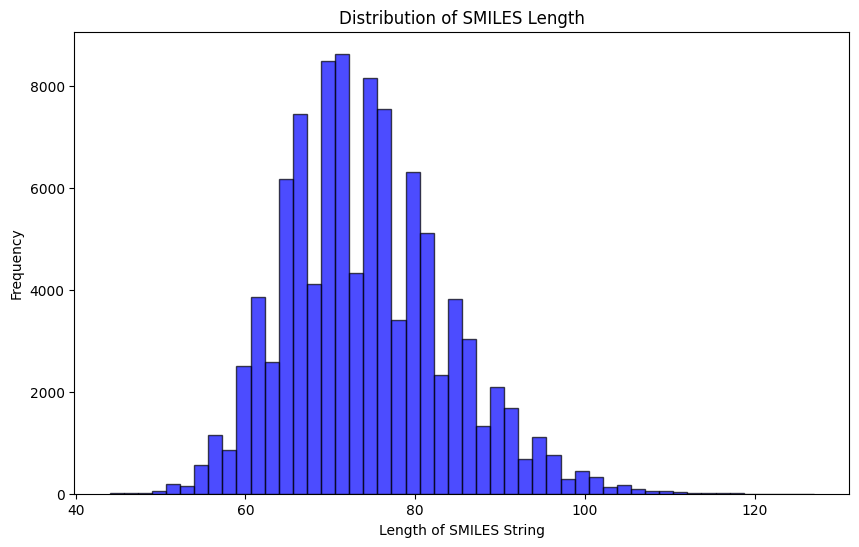

In [23]:
# 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(train['smiles_length'], bins=50, edgecolor='black', color='blue', alpha=0.7)
plt.title('Distribution of SMILES Length')
plt.xlabel('Length of SMILES String')
plt.ylabel('Frequency')
plt.show()

3. 프로틴 별 분자 바인딩 비율

In [24]:
# 프로틴 별 바인딩 비율 계산
binding_rates = train.groupby('protein_name')['binds'].mean()

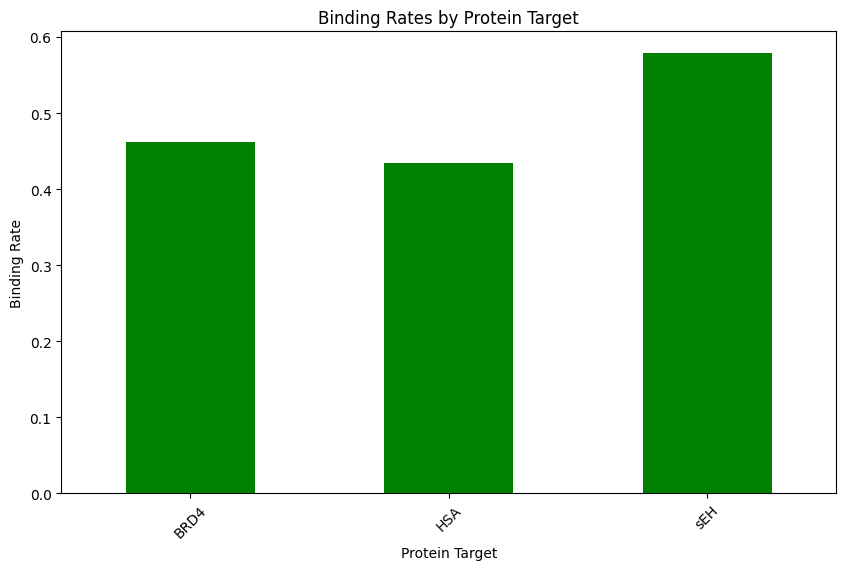

In [25]:
# 비율 시각화
binding_rates.plot(kind='bar', color='green', figsize=(10,6))
plt.title('Binding Rates by Protein Target')
plt.xlabel('Protein Target')
plt.ylabel('Binding Rate')
plt.xticks(rotation=45)
plt.show()

4. 화학적 특성 기반의 분석

In [28]:
# 분자의 화학적 특성 계산
train['logP'] = train['molecule_smiles'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))
train['molecular_weight'] = train['molecule_smiles'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
train['num_h_donors'] = train['molecule_smiles'].apply(lambda x: Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
train['num_h_acceptors'] = train['molecule_smiles'].apply(lambda x: Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))

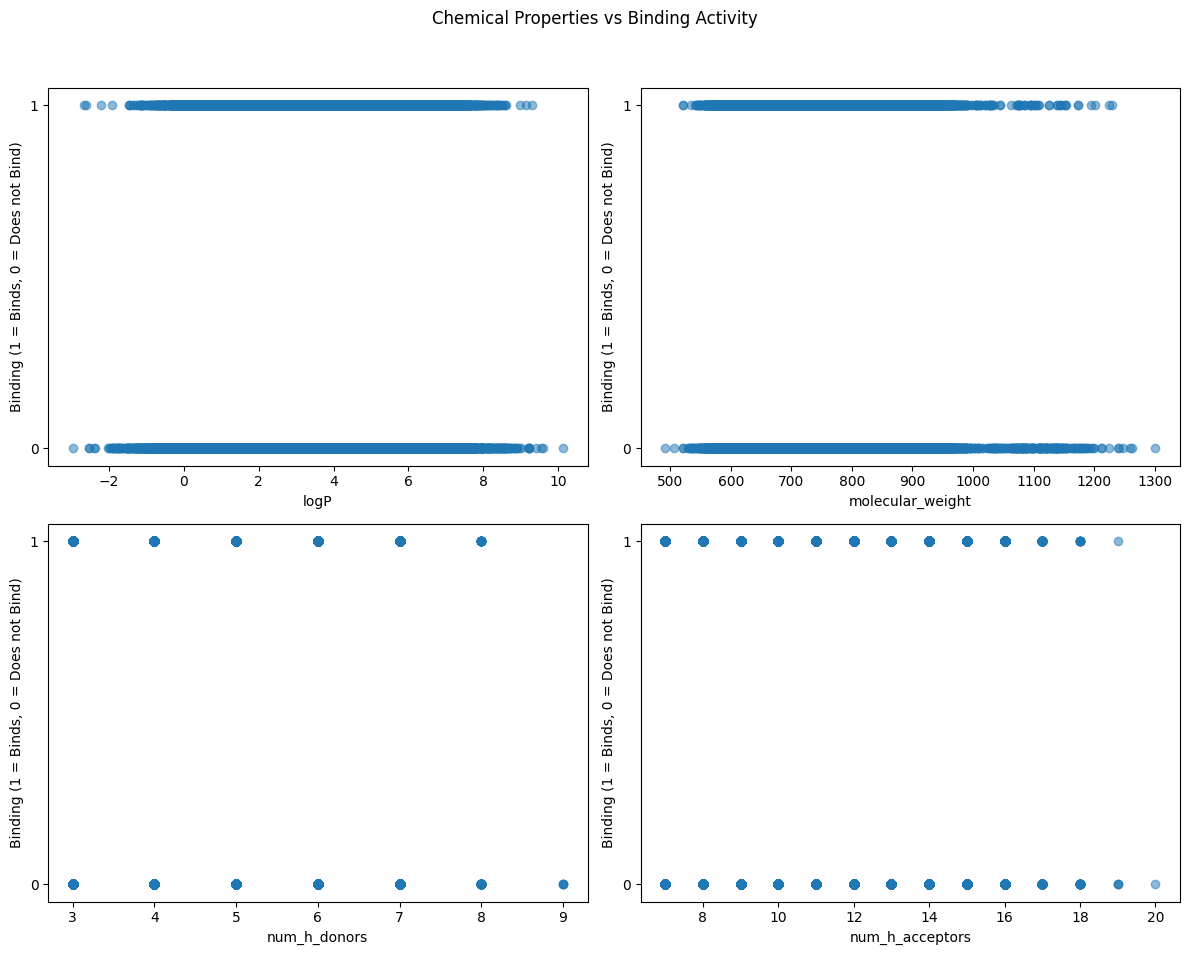

In [44]:
# 특성별 바인딩 여부와의 관계 시각화
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Chemical Properties vs Binding Activity')

properties = ['logP', 'molecular_weight', 'num_h_donors', 'num_h_acceptors']
for ax, prop in zip(axes.flatten(), properties):
    ax.scatter(train[prop], train['binds'], alpha=0.5)
    ax.set_xlabel(prop)
    ax.set_ylabel('Binding (1 = Binds, 0 = Does not Bind)')
    ax.set_yticks([0, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

5. 특성 상관 분석

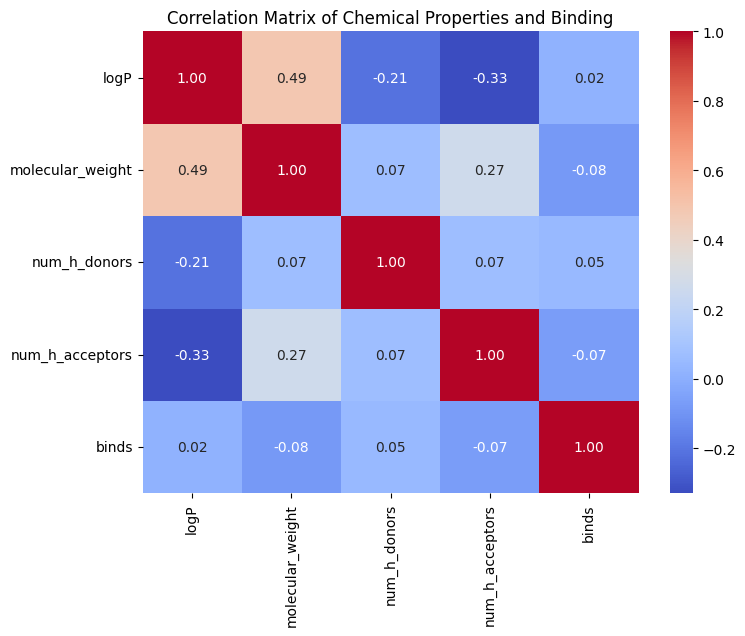

In [32]:
# 특성 간의 상관관계 매트릭스 계산
correlation_matrix = train[['logP', 'molecular_weight', 'num_h_donors', 'num_h_acceptors', 'binds']].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Chemical Properties and Binding')
plt.show()

6. 프로틴별 분자 구조 분석

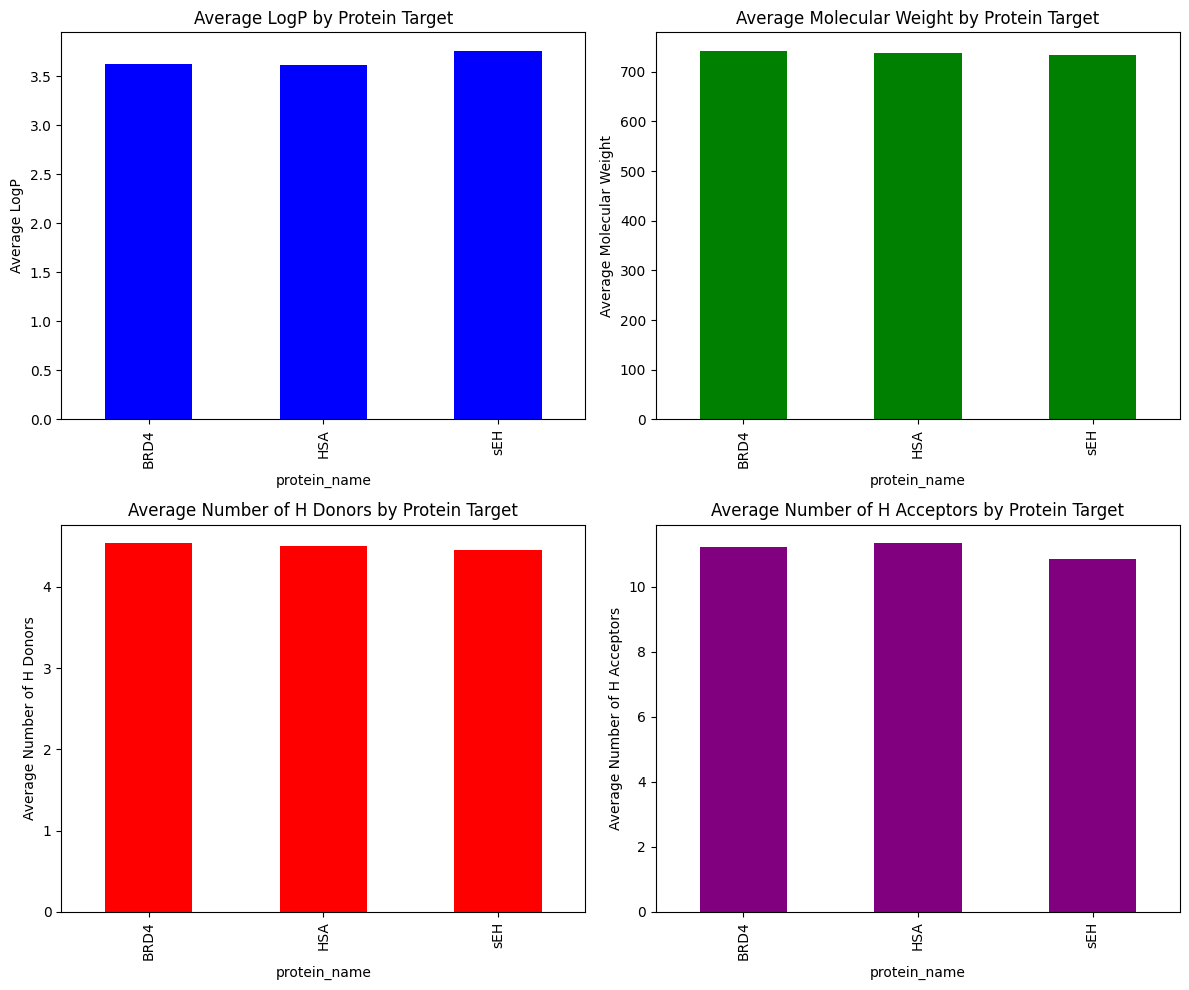

In [42]:
# 프로틴별 화학적 특성의 평균 계산
avg_properties = train.groupby('protein_name')[['logP', 'molecular_weight', 'num_h_donors', 'num_h_acceptors']].mean()

# 프로틴별 특성 비교 시각화
# 각 특성별 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 서브플롯 준비

# logP
avg_properties['logP'].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Average LogP by Protein Target')
axes[0, 0].set_ylabel('Average LogP')

# Molecular Weight
avg_properties['molecular_weight'].plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Average Molecular Weight by Protein Target')
axes[0, 1].set_ylabel('Average Molecular Weight')

# Number of Hydrogen Donors
avg_properties['num_h_donors'].plot(kind='bar', ax=axes[1, 0], color='red')
axes[1, 0].set_title('Average Number of H Donors by Protein Target')
axes[1, 0].set_ylabel('Average Number of H Donors')

# Number of Hydrogen Acceptors
avg_properties['num_h_acceptors'].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Average Number of H Acceptors by Protein Target')
axes[1, 1].set_ylabel('Average Number of H Acceptors')

plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시

7. 서브스트럭처 분석

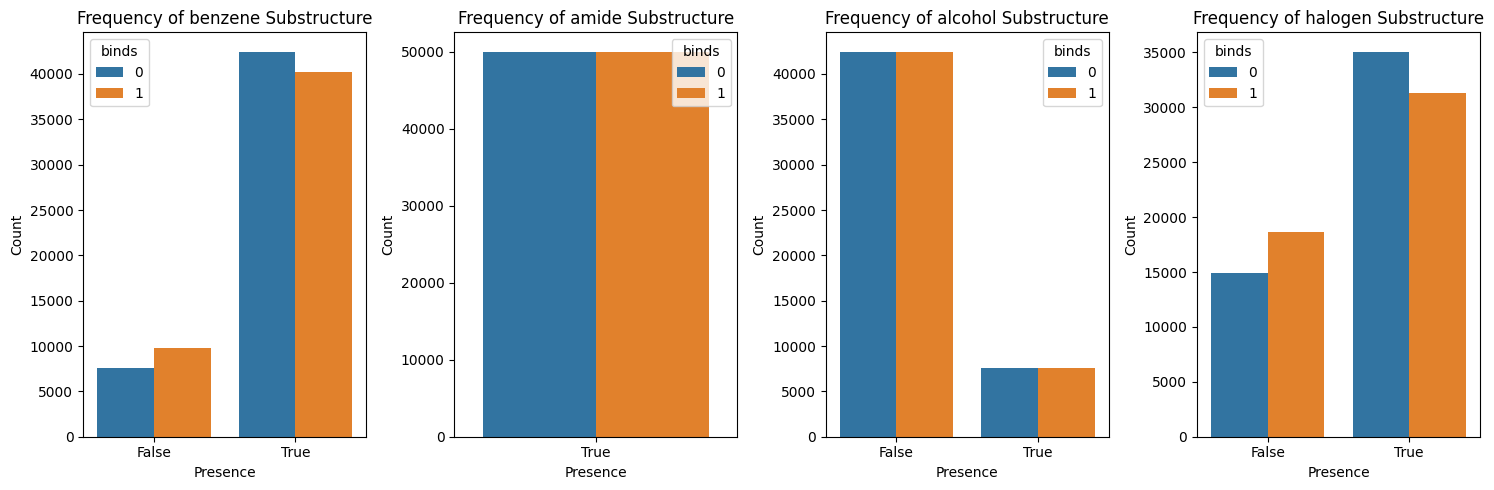

In [34]:
# 서브스트럭처 사전 정의
substructures = {
    'benzene': Chem.MolFromSmarts('c1ccccc1'),  # 벤젠
    'amide': Chem.MolFromSmarts('NC(=O)'),      # 아마이드
    'alcohol': Chem.MolFromSmarts('[OH]'),      # 알코올
    'halogen': Chem.MolFromSmarts('[F,Cl,Br,I]') # 할로겐
}

# 서브스트럭처 빈도 계산
substructure_counts = {key: [] for key in substructures}
for smiles in train['molecule_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    for name, substruct in substructures.items():
        substructure_counts[name].append(mol.HasSubstructMatch(substruct))

substructure_df = pd.DataFrame(substructure_counts)
df = pd.concat([train, substructure_df], axis=1)

# 서브스트럭처 빈도와 바인딩 여부의 관계 시각화
fig, axes = plt.subplots(1, len(substructures), figsize=(15, 5))
for ax, (name, _) in zip(axes, substructures.items()):
    sns.countplot(x=name, hue='binds', data=df, ax=ax)
    ax.set_title(f'Frequency of {name} Substructure')
    ax.set_xlabel('Presence')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

8. 그래프 기반 분자 특성 추출